# BERT for Question Answering


#### Task Description：
Fine-tune BERT on the SQuAD v1.1 question answering task.

*Example:*  
> Context:  
> Tom is 15 years old.   
> 
> 
> Question:  
> How old is Tom? 
>  
> 
> Anwser:   
> 15  


#### Solution:
This program will follow the steps:
1. General Preparation  
2. Data Processing 
3. Loading the Model and Optimizer  
4. Training 
5. Testing 

## 1. General Preparation

### 下载数据集
链接：https://pan.baidu.com/s/1xbMQc6pNwZHQCPDkqdHjWQ?pwd=1234   
请下载数据集，并将训练集和测试集的 JSON 文件保存在 ```dataset/question_answering/``` 目录下。

### 下载预训练模型
链接：https://pan.baidu.com/s/1K-SE6EQ3f0msLYa3vBSRww?pwd=1234   
请下载预训练模型，并保存在当前目录下。

导入计图，以及其他通用包，并开启 GPU 加速。

In [ ]:
# 加载计图，以及其他通用包
import jittor as jt
import time

# 开启 GPU 加速
jt.flags.use_cuda = 1

## 2. Data Processing

### 2.1 Read data from JSON files.

In [2]:
import json
from pathlib import Path

def read_squad(path):
    path = Path(path)
    with open(path, 'rb') as f:
        squad_dict = json.load(f)

    contexts = []
    questions = []
    answers = []
    for group in squad_dict['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                for answer in qa['answers']:
                    contexts.append(context)
                    questions.append(question)
                    answers.append(answer)

    return contexts, questions, answers

train_contexts, train_questions, train_answers = read_squad('dataset/question_answering/train-v1.1.json')
val_contexts, val_questions, val_answers = read_squad('dataset/question_answering/dev-v1.1.json')

In [3]:
def add_end_idx(answers, contexts):
    for answer, context in zip(answers, contexts):
        gold_text = answer['text']
        start_idx = answer['answer_start']
        end_idx = start_idx + len(gold_text)

        # sometimes squad answers are off by a character or two – fix this
        if context[start_idx:end_idx] == gold_text:
            answer['answer_end'] = end_idx
        elif context[start_idx-1:end_idx-1] == gold_text:
            answer['answer_start'] = start_idx - 1
            answer['answer_end'] = end_idx - 1     # When the gold label is off by one character
        elif context[start_idx-2:end_idx-2] == gold_text:
            answer['answer_start'] = start_idx - 2
            answer['answer_end'] = end_idx - 2     # When the gold label is off by two characters

add_end_idx(train_answers, train_contexts)
add_end_idx(val_answers, val_contexts)

Let's have a look at the first training data.

In [4]:
# View the first data.
print(u"Context: \n%s\n" % train_contexts[0])
print(u"Question: \n%s\n" % train_questions[0])
print(u"Answer: %s" % train_answers[0]["text"])
print(train_answers[0])

Context: 
Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.

Question: 
To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?

Answer: Saint Bernadette Soubirous
{'answer_start': 515, 'text': 'Saint Bernadette Soubirous', 'answer_end': 541}


In [5]:
# Choose how much data to train and test.
train_length = len(train_answers)
train_start, train_end = 0, 1000
train_contexts = train_contexts[train_start:train_end]
train_questions = train_questions[train_start:train_end]
train_answers = train_answers[train_start:train_end]

val_length = len(val_answers)
val_start, val_end = 0, 1000
val_contexts = val_contexts[val_start:val_end]
val_questions = val_questions[val_start:val_end]
val_answers = val_answers[val_start:val_end]

print("Train set length from %s to %s" % (train_length, train_end))
print("Validation set length from %s to %s" % (val_length, val_end))

Train set length from 87599 to 1000
Validation set length from 34726 to 1000


### 2.2 Tokenization

In [6]:
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained('bert-large-uncased')

# Tokenization
train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
val_encodings = tokenizer(val_contexts, val_questions, truncation=True, padding=True)

In [7]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length

    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)

### 2.3 Turn data into a Dataset object

Define a Dataset class.

In [8]:
class SquadDataset(jt.dataset.Dataset):
    def __init__(self, encodings, labels):
        super().__init__()
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: jt.array(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]["text"].lower()
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SquadDataset(train_encodings, train_answers).set_attrs(batch_size=4, shuffle=True)
val_dataset = SquadDataset(val_encodings, val_answers).set_attrs(batch_size=1, shuffle=False)

## 3. Loading the Model and Optimizer 

In [9]:
from model import BertForQuestionAnswering, BertConfig
from jittor.optim import AdamW

# Loading the model
configuration = BertConfig(num_hidden_layers=24, hidden_size=1024, num_attention_heads=16, intermediate_size=4096)
model = BertForQuestionAnswering(configuration)
model.load_state_dict(jt.load("bert-large-uncased-qa-jittor.pkl")) # load pre-trained model

# Loading the optimizer
optim = AdamW(model.parameters(), lr=1e-5)

## 4. Training

Prepare some utility functions.

In [10]:
# Prediction function
def predict(inputs, outputs):
    answer_start_index = jt.argmax(outputs["start_logits"], dim=1)[0]
    answer_end_index = jt.argmax(outputs["end_logits"], dim=1)[0]
    predict_answer_tokens = [inputs["input_ids"][i][int(answer_start_index[i]) : int(answer_end_index[i]) + 1].numpy() for i in range(len(inputs["input_ids"]))]
    predictions = [tokenizer.decode(tokens) for tokens in predict_answer_tokens]
    return predictions

Train the model.

In [11]:
# Training
import numpy as np
from tqdm import tqdm

# Set the number of epoch
epoch = 2

# Start training
model.train()

train_loss = list()
train_accuracies = list()
for epoch_i in range(epoch):
    print('Epoch %s/%s' % (epoch_i + 1, epoch))
    time.sleep(0.3)

    correct = 0
    count = 0
    epoch_loss = list()
    
    pbar = tqdm(train_dataset, total=len(train_dataset)//train_dataset.batch_size)
    for batch in pbar:
        optim.zero_grad()
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        start_positions = batch['start_positions']
        end_positions = batch['end_positions']
        labels = batch['labels']
        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs['loss']
        optim.step(loss)
        
        # make predictions
        predictions = predict(batch, outputs)

        # count accuracy
        correct += np.sum(np.array(predictions) == np.array(labels))
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'Loss': '{:.3f}'.format(loss.item()),
            'Accuracy': '{:.3f}'.format(accuracy)
        })
        
        # record the loss for each batch
        epoch_loss.append(loss.item())
        
    pbar.close()
    
    # record the loss and accuracy for each epoch
    train_loss += epoch_loss
    train_accuracies.append(accuracy)

Epoch 1/2


  0%|          | 0/250 [00:00<?, ?it/s]
Compiling Operators(76/76) used: 4.31s eta:    0s 
100%|██████████| 250/250 [02:02<00:00,  2.05it/s, Loss=3.326, Accuracy=0.029]


Epoch 2/2


100%|██████████| 250/250 [02:03<00:00,  2.03it/s, Loss=2.762, Accuracy=0.307]


Visualise the training loss and accuracy.

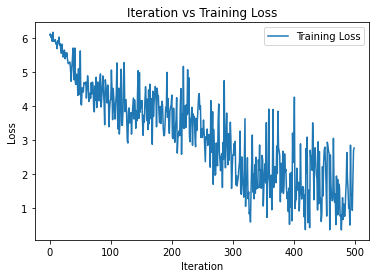

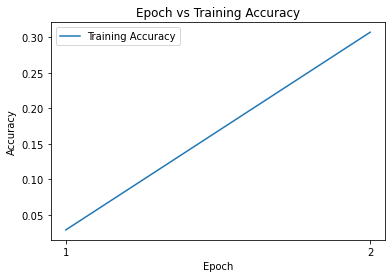

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Iteration vs Training Loss
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Training Loss")  
plt.legend()
plt.show()

# Plot Epoch vs Training Accuracy
acc_X = np.arange(len(train_accuracies))+1                          
plt.plot(acc_X, train_accuracies,"-", label="Training Accuracy")
plt.xticks(acc_X)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Training Accuracy")  
plt.legend()
plt.show()

## 5. Testing

Test the model.

In [13]:
# Testing

# Start testing
model.eval()

with jt.no_grad():
    
    correct = 0
    count = 0
    record = {"labels":list(), "predictions":list()}
    
    pbar = tqdm(val_dataset, total=len(val_dataset)//val_dataset.batch_size)
    for batch in pbar:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        start_positions = batch['start_positions']
        end_positions = batch['end_positions']
        labels = batch['labels']
        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs['loss']
        
        # make predictions
        predictions = predict(batch, outputs)

        # count accuracy
        correct += np.sum(np.array(predictions) == np.array(labels))
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'loss': '{:.3f}'.format(loss.item()),
            'accuracy': '{:.3f}'.format(accuracy)
        })
    
        # record the results
        record["labels"] += labels
        record["predictions"] += predictions
        
    pbar.close()
    
time.sleep(0.3)
print("The final accuracy on the test dataset: %s%%" % round(accuracy*100,4))

100%|██████████| 1000/1000 [00:50<00:00, 20.00it/s, loss=7.894, accuracy=0.367]


The final accuracy on the test dataset: 36.7%


Check the result.

In [14]:
# Convert test record to a pandas DataFrame object
import pandas as pd
from pandas.core.frame import DataFrame
df = DataFrame(record)
df.columns = ["Ground Truth","Model Prediction"]

# Show test result
# pd.set_option('display.max_rows', None)    # Display all rows
# df

# Show incorrect predictions 
df[df["Ground Truth"]!=df["Model Prediction"]]

,Ground Truth,Model Prediction
6,"santa clara, california",levi's stadium
8,levi's stadium in the san francisco bay area a...,levi's stadium
12,gold,roman numerals
13,gold,roman numerals
14,gold,roman numerals
...,...,...
992,new england patriots,"pittsburgh steelers in the divisional round, 2..."
993,patriots,"pittsburgh steelers in the divisional round, 2..."
997,thomas davis,"thomas davis, an 11 - year veteran who had alr..."
998,"thomas davis,","thomas davis, an 11 - year veteran who had alr..."


## Inference

In [15]:
from utils.qa import InferQA

infer_qa = InferQA(model, tokenizer, data_path="dataset/question_answering/dev-v1.1.json")
infer_qa.infer()

100%|██████████| 48/48 [05:06<00:00,  6.38s/it, total=10570, match=0.397, f1=0.507]

exact_match: 0.397, f1: 0.507


## Manual Test
Now, let's have a manual test on this trained model.  

First, you need to input a context and a question. Then, our trained model will predict the answer. In this way, we can check the performance of the model.

To perform a manual test, please run the following code block.

In [16]:
"""
- Manual Test -

Input a context and a question. Then, our trained model will predict the answer.

Example：
Input Context: "Tom is 15 years old."
Input Question: "How old is Tom?"
Expect: 15

"""

manual_test = True
count = 1
print("Let's start our manual test.\n")
time.sleep(0.3)
while(manual_test):
    
    context = input("Context:\n")
    print()
    question = input("Question:\n")

    # Tokenization
    inputs = tokenizer(context, question)
    for key in inputs.keys():
        inputs[key] = jt.array(inputs[key]).unsqueeze(0)
    
    # Model makes its prediction
    outputs = model(**inputs)
    prediction = predict(inputs, outputs)

    # Check the performance
    print("\nAnswer:\n%s\n" % prediction[0])
    
    manual_test = input("Try again? y/n\n")=="y"
    if manual_test:
        count = count + 1
        print("--------------------------------------- %s ---------------------------------------" % count)

Let's start our manual test.

Context:
Tom is 15 years old.

Question:
How old is Tom?

Answer:
15

Try again? y/n
n
